In [1]:
import pandas as pd
import multiprocessing
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

from model.helper import load_data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
d = load_data()

Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


Merge the identity and transaction datasets

In [4]:
train = pd.merge(d['train_transaction'], d['train_identity'], on='TransactionID', how='left')

In [5]:
test = pd.merge(d['test_transaction'], d['test_identity'], on='TransactionID', how='left')

It is convenient to have indexes of known fraudulent transactions.

In [6]:
is_fraud_idx = (train.isFraud==1)

The data set is unbanaced, only 4% of transactions are f. 

In [7]:
is_fraud_idx.sum()/(~is_fraud_idx).sum()

0.03625870143908247

Before training our model, we need to filter out potentially insignificat featues.

Since we have two populations ($F$ and $\bar{F}$), we need to find features, which are significantly different in two populations. To do that, we use a dissimilarity index $D_f$. For catigorical featues we define it as follows [https://www.tandfonline.com/doi/abs/10.1080/03610928908830127]:

$$D_f = \dfrac{1}{2}\sum_x 
\left|P_f(F|x) - P_f(\bar{F}|x)\right|,  $$
where $P_f(F|x)$ is the probality of feature $f$ having a value $x$ is the transaction if fraudulet $F$. By definition $0\leqslant D_f \leqslant 1$. Features which have higher dissimilarities should be better predictors for our classifier


In [8]:
def calc_feature_dissimilarity(col, is_fraud_idx):
    f0 = col.loc[~is_fraud_idx].value_counts(dropna=False, normalize=True)
    f1 = col.loc[is_fraud_idx].value_counts(dropna=False, normalize=True)
    ed = pd.concat([f0, f1], axis=1, sort=False)
    ed.columns = ['notFraud', 'isFraud']
    ed = ed.fillna(0)
    ed['dissim'] = 0.5*np.abs(ed.notFraud - ed.isFraud)
    return ed.dissim.sum()

In [9]:
gc.collect()

95

In [10]:
diss = train.apply(lambda c: calc_feature_dissimilarity(c, is_fraud_idx))
diss = diss.reset_index().rename(columns={'index':'feature', 0:'dissimilarity'})

Let us try dropping features with $D_f<0.1$

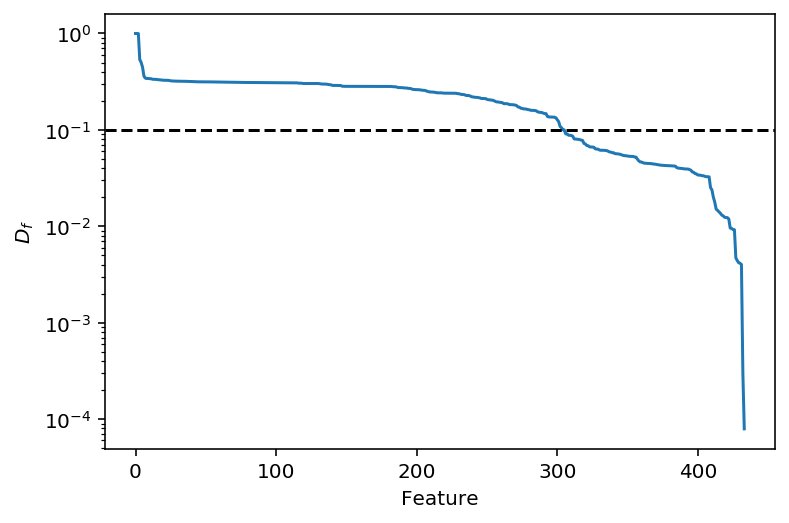

In [11]:
plt.plot(diss.sort_values('dissimilarity', ascending=False).dissimilarity.values)
plt.axhline(0.1, ls='--', color='k')
plt.xlabel('Feature')
plt.ylabel('$D_f$')
plt.yscale('log')

In [12]:
drop_features = diss[(diss.dissimilarity<0.1)].feature

In [13]:
train_filtered = train.drop(columns=drop_features).copy()
test_filtered = test.drop(columns=drop_features).copy()

In [14]:
train_filtered.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,102.0,credit,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [15]:
X_train = train_filtered.drop(columns  = ['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
X_test = test_filtered.drop(columns=['TransactionID', 'TransactionDT'], axis=1)

In [16]:
y_train = train_filtered['isFraud']

In [17]:
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

In [18]:
gc.collect()

9872

Poor man's label encoding

In [19]:
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

In [20]:
gc.collect()

22

Ladies and gentle men, START YOU ENGINES!

In [21]:
clf = lgb.LGBMClassifier(
    max_bin = 63,
    num_leaves = 255,
    num_iterations = 500,
    learning_rate = 0.01,
    tree_learner = 'serial',
    task = 'train',
    is_training_metric = False,
    min_data_in_leaf = 1,
    min_sum_hessian_in_leaf = 100,
    sparse_threshold=1.0,
    num_thread = -1,
    save_binary= True,
    seed= 42,
    feature_fraction_seed = 42,
    bagging_seed = 42,
    drop_seed = 42,
    data_random_seed = 42,
    objective = 'binary',
    boosting_type = 'gbdt',
    verbose = 1,
    metric = 'auc',
    is_unbalance = True,
    boost_from_average = False,
)

In [22]:
%time clf.fit(X_train, y_train)


/home/ivlis/.conda/envs/jlab/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 42min 10s, sys: 8.94 s, total: 42min 19s
Wall time: 5min 24s


LGBMClassifier(bagging_seed=42, boost_from_average=False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, data_random_seed=42,
               drop_seed=42, feature_fraction_seed=42, importance_type='split',
               is_training_metric=False, is_unbalance=True, learning_rate=0.01,
               max_bin=63, max_depth=-1, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=1, min_split_gain=0.0,
               min_sum_hessian_in_leaf=100, n_estimators=100, n_jobs=-1,
               num_iterations=500, num_leaves=255, num_thread=-1,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, save_binary=True, ...)

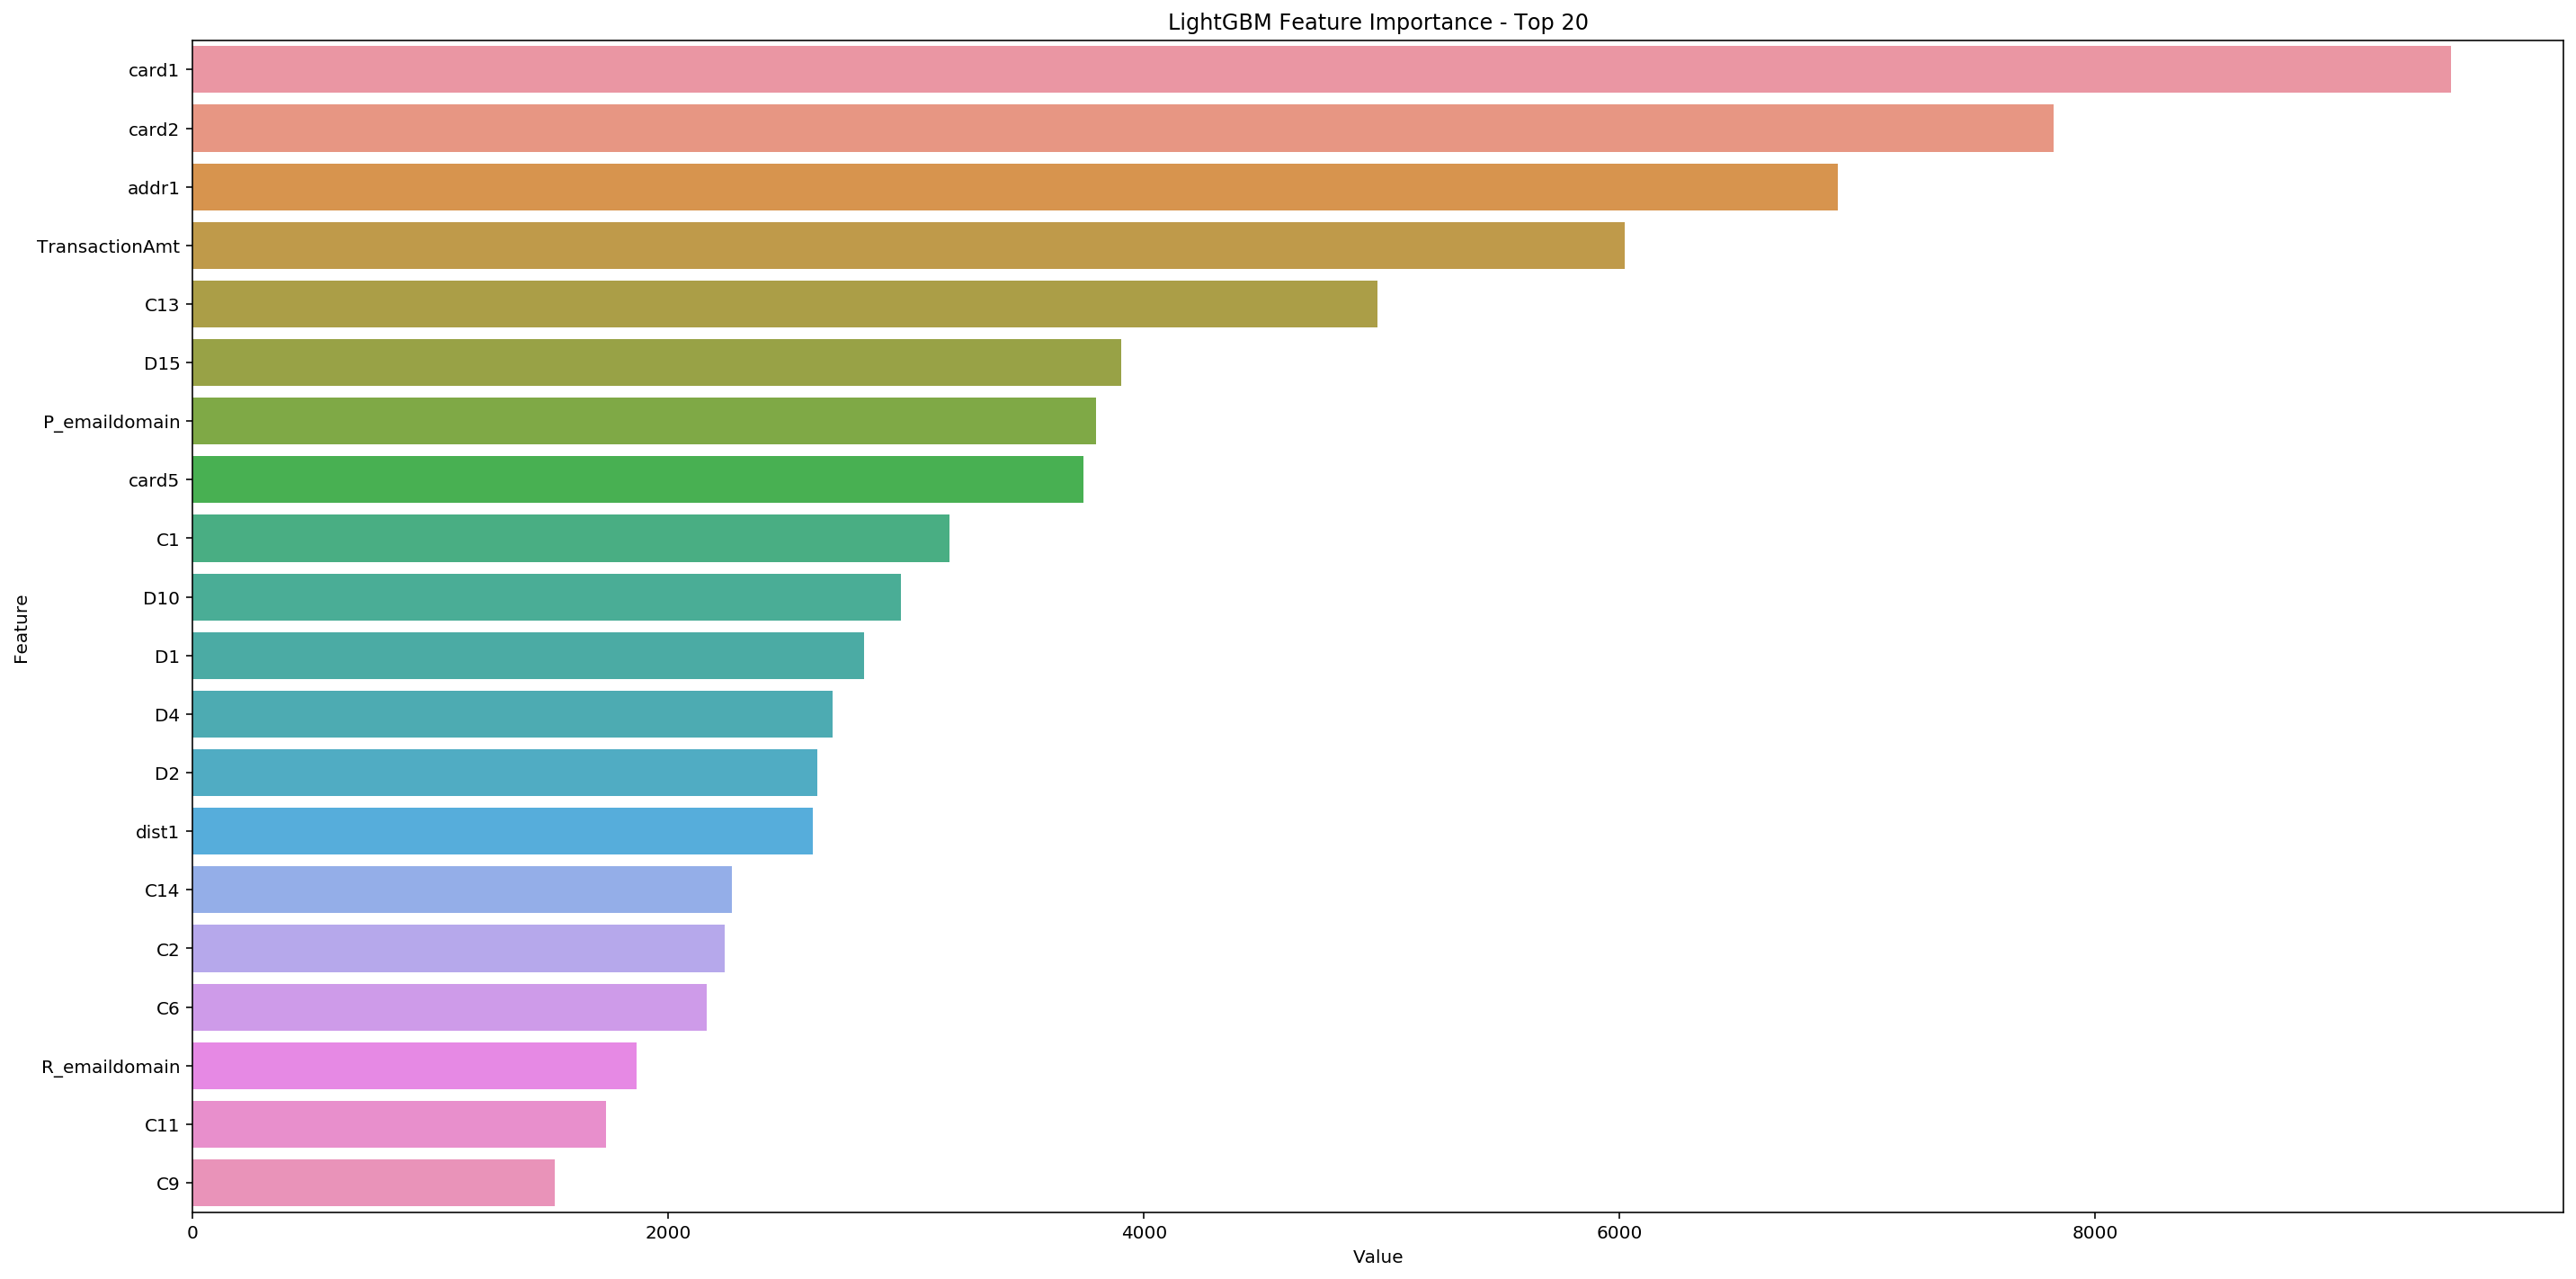

In [23]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
plt.title('LightGBM Feature Importance - Top 20')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances.png')

In [24]:
sample_submission = d['sample_submission']
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]


In [25]:
sample_submission.to_csv('result.csv', index=False)